# GMDH with Rough Set Theory - 1 Layer Implementation

This notebook implements a Group Method of Data Handling (GMDH) neural network with Rough Set Theory. The architecture consists of:
- **1 Layer GMDH**: Feature extraction using polynomial combinations
- **Rough Set Neural Network**: Final prediction using rough set theory with upper and lower bounds

## Overview
GMDH is combined with rough set theory to handle uncertainty in predictions by using interval-valued outputs (upper and lower bounds).


In [ ]:
#importing essential libraries
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, clear_output

## Import Required Libraries

Import essential libraries for data manipulation, numerical operations, visualization, and preprocessing.


In [ ]:
#reading the Dataset and drop the torget
data = pd.read_excel('/content/drive/MyDrive/Time-series/Lorenz Dataset.xlsx' ,header=None)
input = data.iloc[:,:-1].values
target = data.iloc[:,-1].values

## Load and Prepare Dataset

Load the Lorenz time-series dataset from Excel file. Separate input features (all columns except last) and target variable (last column).


In [ ]:
print(data.shape)

(1991, 10)


## Check Data Shape

Display the shape of the dataset to verify dimensions.


In [ ]:
# Create MinMaxScaler instances for input and target separately
scaler_input = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

# Normalize the input and target variables separately
input = scaler_input.fit_transform(input)
target = scaler_target.fit_transform(target.reshape(-1, 1))

## Normalize Data

Normalize input and target variables separately using MinMaxScaler to scale values between 0 and 1.


In [ ]:
total_rows = len(input)
train_size = int(0.7 * total_rows)
valid_size = int(0.15 * total_rows)
test_size = int(0.15 * total_rows)

# split the DataFrame
X_train = input[:train_size, :]
X_valid = input[train_size:train_size + valid_size, :]
X_test = input[train_size + valid_size:, :]
y_train = target[:train_size]
y_valid = target[train_size:train_size + valid_size]
y_test = target[train_size + valid_size:]

## Split Dataset

Split the dataset into training (70%), validation (15%), and test (15%) sets.


In [ ]:
#defining needed functions
def Choosing_pairs(arr):
    pairs = np.array([(arr[i], arr[j]) for i in range(len(arr)) for j in range(i+1, len(arr))])
    return pairs

def plot_regression_line(x, y, label):
    coefficients = np.polyfit(x, y, 1)
    polynomial = np.poly1d(coefficients)
    x_line = np.linspace(min(x), max(x), 100)
    y_line = polynomial(x_line)
    plt.plot(x_line, y_line, label=label)

def remove_neuron(weight,mses, threshold_mse):
    indexlist = []
    i = 0
    for data in mses:
      randomnumber = np.random.rand()
      if data < threshold_mse:
        indexlist.append(i)
      i+=1
    weight_copy = np.copy(weight)
    weight_copy[indexlist,:] = 0
    return weight_copy , indexlist

def GMDH(Choosing_pairs,weight):
  X = np.zeros((weight.shape[0],6))
  net = np.zeros(weight.shape[0])
  i = 0

  for pair in Choosing_pairs:
    X[i] = np.array([pair[0] ,pair[1], pair[0] * pair[0], pair[1] * pair[1], pair[1] * pair[0], 1])
    net[i] = X[i].reshape(-1,1).T.dot(weight[i])
    i+=1
  return net,X

## Define Helper Functions

Define utility functions for GMDH:
- **Choosing_pairs**: Creates all possible pairs from input array
- **plot_regression_line**: Plots regression line for visualization
- **remove_neuron**: Removes neurons with high MSE (pruning)
- **GMDH**: Core GMDH function that computes polynomial features


In [ ]:
n1 = 4
n2 = n1*(n1-1)//2
eta = 0.001
epoch = 150
a, b = -1, 1

output_data_train = np.zeros(train_size)
output_data_test = np.zeros(test_size)
mse_train = np.zeros(epoch)
mse_test = np.zeros(epoch)
mse_error_train = np.zeros((train_size,n2))
mse_error_vlaidation = np.zeros((valid_size,n2))
mse_error_test = np.zeros((test_size,n2))


## Initialize Parameters

Set up GMDH network parameters and initialize arrays for storing outputs and errors.


In [ ]:
#making input for GMDH
GMDH_input = list()
for i in range(data.shape[0]):
    input_data = input[i, :4]
    GMDH_input.append(Choosing_pairs(input_data)) # 6 * 2

#Defining 1 layer GMDH
w1 = np.random.uniform(a, b, (n2, 6)) #100*3
net1 = np.zeros(n2) #100 * 1
o1 = np.zeros(n2) #100 * 1

for t in range(epoch):
    error = np.zeros((n2))

    for i in range(train_size):

      # Feedforward
        net1 , X = GMDH(GMDH_input[i] , w1)
        o1 = net1

        # Backpropagation
        target = np.full(n2, input[i, 4])
        error = target - o1 # n2*1

        for j in range(n2):
          w1[j] += eta * error[j]*X[j]


    for i in range(train_size):
        net1 , X = GMDH(GMDH_input[i] , w1)
        o1 = net1
        mse_error_train[i] = input[i, 4] - o1

    column_means = np.mean(mse_error_train**2, axis=0)
    print(f"MSE of train {t}: {column_means}")

    for i in range(valid_size):
        net1 , X = GMDH(GMDH_input[train_size+i] , w1)
        o1 = net1
        mse_error_vlaidation[i] = input[train_size+i, 4] - o1

MSE of train 0: [0.02415221 0.00853628 0.07128368 0.01180094 0.12016409 0.02666687]
MSE of train 1: [0.00384389 0.00511704 0.04680027 0.00390265 0.07076264 0.0028017 ]
MSE of train 2: [0.00348472 0.00350292 0.03329628 0.00363237 0.04840662 0.00256824]
MSE of train 3: [0.00334678 0.0024934  0.02481471 0.00351249 0.03395741 0.00253194]
MSE of train 4: [0.00325628 0.00185071 0.01943097 0.0034301  0.02472091 0.0024973 ]
MSE of train 5: [0.00319632 0.00143985 0.01600058 0.00336935 0.01881276 0.00246324]
MSE of train 6: [0.00315614 0.00117621 0.01380407 0.00332197 0.01501841 0.00242977]
MSE of train 7: [0.00312878 0.0010062  0.01238657 0.00328292 0.01256659 0.00239684]
MSE of train 8: [0.00310978 0.00089579 0.01146047 0.00324907 0.01096821 0.00236442]
MSE of train 9: [0.00309628 0.0008234  0.01084402 0.00321848 0.00991309 0.00233249]
MSE of train 10: [0.00308643 0.00077531 0.01042247 0.00318995 0.00920433 0.00230103]
MSE of train 11: [0.00307901 0.00074278 0.01012343 0.00316276 0.00871691 0.

## Train GMDH Layer 1

Train the first GMDH layer with feedforward and backpropagation to learn polynomial combinations of input features.


In [ ]:
#removing Neurons from GMDH
column_means = np.mean(mse_error_vlaidation, axis=0)
mse_validation = np.mean(np.abs(column_means), axis=0)
print(f"MSE of Validation : {column_means}")
print(f"Total absolute  Mse : {mse_validation}")
print("Old Weight Matrix : ")
print(w1)
w1_new , removed_index_list= remove_neuron(w1,np.abs(column_means), mse_validation)
print("New Weight Matrix : ")
print(w1_new)


MSE of Validation : [ 0.00313175  0.00043549  0.00048304  0.00110598  0.0003115  -0.00096629]
Total absolute  Mse : 0.0010723413159493273
Old Weight Matrix : 
[[ 1.20782226e+00 -2.61369296e-01 -7.12348105e-01 -3.03756838e-01
   1.03935455e+00  1.72716222e-02]
 [-1.42473612e-01  1.03912563e+00  1.77903977e-02  4.33349172e-01
  -3.68090887e-01  2.50472353e-02]
 [ 8.62060060e-01 -3.76360757e-01 -1.74662195e-01  6.53611993e-01
   1.92452467e-04  1.08792789e-01]
 [ 1.00497535e+00 -2.69327271e-01 -1.70579027e-01  8.41463598e-01
  -4.33648066e-01  5.79255466e-02]
 [ 2.64968981e-01  2.59061896e-01  6.18561161e-01 -8.43646639e-02
  -9.07566850e-02  1.00575030e-01]
 [-1.70380586e-01  8.89685165e-01 -5.81858472e-01  3.15530880e-01
   5.30418506e-01  5.91670983e-02]]
New Weight Matrix : 
[[ 1.20782226 -0.2613693  -0.71234811 -0.30375684  1.03935455  0.01727162]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          

## Prune GMDH Neurons

Remove neurons with high validation error to reduce model complexity and prevent overfitting.


In [ ]:
input_data1 = np.zeros((data.shape[0],w1_new.shape[0]))
for i in range(train_size):
    net1 , X = GMDH(GMDH_input[i] , w1_new)
    o1 = net1
    input_data1[i] = o1
    mse_error_train[i] = input[i, 4] - o1

column_means = np.mean(mse_error_train, axis=0)
print(f"MSE of train : {column_means}")

for i in range(valid_size):
    net1 , X = GMDH(GMDH_input[train_size+i] , w1_new)
    o1 = net1
    input_data1[i+train_size] = o1
    mse_error_vlaidation[i] = input[train_size+i, 4] - o1
column_means = np.mean(mse_error_vlaidation, axis=0)
print(f"MSE of vlaidation : {column_means}")

for i in range(test_size):
    net1 , X = GMDH(GMDH_input[train_size+valid_size+i] , w1_new)
    o1 = net1
    input_data1[i+train_size+valid_size] = o1
    mse_error_test[i] = input[train_size + valid_size + i, 4] - o1

column_means = np.mean(mse_error_test, axis=0)
print(f"MSE of test : {column_means}")
input_data1 = np.delete(input_data1,removed_index_list, axis=1)
print(input_data1)

MSE of train : [ 4.50096179e-04  4.48474286e-01  4.48474286e-01 -3.36237586e-05
  4.48474286e-01  4.48474286e-01]
MSE of vlaidation : [0.00313175 0.41169526 0.41169526 0.00110598 0.41169526 0.41169526]
MSE of test : [0.00445322 0.59304897 0.59304897 0.00356589 0.59304897 0.59304897]
[[0.48758189 0.47970574]
 [0.49006707 0.48182744]
 [0.49227684 0.48373652]
 ...
 [0.51499414 0.50169088]
 [0.         0.        ]
 [0.         0.        ]]


## Extract Features from GMDH Layer 1

Extract features from the trained and pruned GMDH layer to use as input for the next layer.


In [ ]:
#making input for GMDH
GMDH_input = list()
for i in range(data.shape[0]):
    input_data = input[i, :4]
    GMDH_input.append(Choosing_pairs(input_data)) # 6 * 2

#Defining 1 layer GMDH
w1 = np.random.uniform(a, b, (n2, 6)) #100*3
net1 = np.zeros(n2) #100 * 1
o1 = np.zeros(n2) #100 * 1

for t in range(epoch):
    error = np.zeros((n2))

    for i in range(train_size):

      # Feedforward
        net1 , X = GMDH(GMDH_input[i] , w1)
        o1 = net1

        # Backpropagation
        target = np.full(n2, input[i, 4])
        error = target - o1 # n2*1

        for j in range(n2):
          w1[j] += eta * error[j]*X[j]


    for i in range(train_size):
        net1 , X = GMDH(GMDH_input[i] , w1)
        o1 = net1
        mse_error_train[i] = input[i, 4] - o1

    column_means = np.mean(mse_error_train**2, axis=0)
    print(f"MSE of train {t}: {column_means}")

    for i in range(valid_size):
        net1 , X = GMDH(GMDH_input[train_size+i] , w1)
        o1 = net1
        mse_error_vlaidation[i] = input[train_size+i, 4] - o1

MSE of train 0: [0.03766481 0.02927536 0.03034724 0.11197113 0.06926729 0.10782943]
MSE of train 1: [0.02083502 0.01889355 0.01888722 0.0693578  0.04223675 0.07146777]
MSE of train 2: [0.01349782 0.01262785 0.01210343 0.04473575 0.02746937 0.04802004]
MSE of train 3: [0.0089735  0.00866427 0.00783138 0.0293085  0.0181932  0.03309022]
MSE of train 4: [0.006129   0.00614426 0.00512833 0.01958559 0.01231027 0.02359302]
MSE of train 5: [0.00433857 0.00453865 0.0034176  0.01345565 0.00857252 0.01753832]
MSE of train 6: [0.00321252 0.00351317 0.00233519 0.00959176 0.00619468 0.01366429]
MSE of train 7: [0.00250521 0.00285605 0.00165055 0.00715661 0.00467961 0.01117234]
MSE of train 8: [0.00206164 0.00243302 0.00121765 0.00562175 0.00371228 0.00955706]
MSE of train 9: [0.00178401 0.0021589  0.00094396 0.00465376 0.00309301 0.00849846]
MSE of train 10: [0.00161066 0.00197964 0.0007709  0.00404235 0.00269512 0.00779384]
MSE of train 11: [0.00150275 0.00186092 0.00066141 0.00365499 0.00243822 0.

## Train Second GMDH Layer

Train a second GMDH layer using the features extracted from the first layer.


In [ ]:
#removing Neurons from GMDH
column_means = np.mean(mse_error_vlaidation, axis=0)
mse_validation = np.mean(np.abs(column_means), axis=0)
print(f"MSE of Validation : {column_means}")
print(f"Total absolute  Mse : {mse_validation}")
print("Old Weight Matrix : ")
print(w1)
w1_new , removed_index_list= remove_neuron(w1,np.abs(column_means), mse_validation)
print("New Weight Matrix : ")
print(w1_new)


MSE of Validation : [0.00196731 0.00081552 0.00115544 0.00192417 0.00282856 0.00016785]
Total absolute  Mse : 0.0014764751877894549
Old Weight Matrix : 
[[ 0.01971879  0.97620535  0.03497796  0.7610757  -0.81700009  0.00655025]
 [ 0.74984254  0.08757478 -0.64209862  0.99948704 -0.21835698  0.03739635]
 [ 0.27631239  0.74490478  0.0204802   0.41120494 -0.46116348 -0.00269534]
 [ 0.80235639 -0.01677283  0.43311762 -0.05139586 -0.19381324  0.04777502]
 [ 0.86309797  0.09538248  0.23245945  0.12755949 -0.3319043   0.01046141]
 [ 0.8057057  -0.25016331  0.34862594 -0.1450733   0.21249281  0.09354776]]
New Weight Matrix : 
[[ 0.01971879  0.97620535  0.03497796  0.7610757  -0.81700009  0.00655025]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.80235639 -0.01677283  0.43311762 -0.05139586 -0.19381324  0.04777502]
 [ 0.86309797  0.09538248  0.23245945  0.12755949 -0.3319043   0.01046141]


## Prune Second GMDH Layer

Remove neurons with high validation error from the second GMDH layer.


In [ ]:
input_data2 = np.zeros((data.shape[0],w1_new.shape[0]))
for i in range(train_size):
    net1 , X = GMDH(GMDH_input[i] , w1_new)
    o1 = net1
    input_data2[i] = o1
    mse_error_train[i] = input[i, 4] - o1

column_means = np.mean(mse_error_train, axis=0)
print(f"MSE of train : {column_means}")

for i in range(valid_size):
    net1 , X = GMDH(GMDH_input[train_size+i] , w1_new)
    o1 = net1
    input_data2[i+train_size] = o1
    mse_error_vlaidation[i] = input[train_size+i, 4] - o1
column_means = np.mean(mse_error_vlaidation, axis=0)
print(f"MSE of vlaidation : {column_means}")

for i in range(test_size):
    net1 , X = GMDH(GMDH_input[train_size+valid_size+i] , w1_new)
    o1 = net1
    input_data2[i+train_size+valid_size] = o1
    mse_error_test[i] = input[train_size + valid_size + i, 4] - o1

column_means = np.mean(mse_error_test, axis=0)
print(f"MSE of test : {column_means}")
input_data2 = np.delete(input_data2,removed_index_list, axis=1)
print(input_data2)

MSE of train : [1.91776917e-04 4.48474286e-01 4.48474286e-01 2.33804637e-04
 5.40269350e-04 4.48474286e-01]
MSE of vlaidation : [0.00196731 0.41169526 0.41169526 0.00192417 0.00282856 0.41169526]
MSE of test : [0.00355756 0.59304897 0.59304897 0.00368402 0.00217313 0.59304897]
[[0.49399699 0.48102385 0.49074019]
 [0.4961118  0.48326173 0.49294881]
 [0.49801259 0.48526675 0.49493102]
 ...
 [0.51575264 0.50489443 0.51390658]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]


## Extract Features from GMDH Layer 2

Extract features from the second GMDH layer to use as input for the rough set neural network.


In [ ]:
print(input_data2.shape)

(1991, 3)


## Prepare Data for Rough Set Network

Split the extracted features into training and test sets for the rough set neural network.


In [ ]:
total_rows = len(input_data2)

# split the DataFrame
X_train = input_data2[:train_size, :]
X_test = input_data2[train_size:train_size + valid_size, :]
y_train = input[:train_size, 4]
y_test = input[train_size:train_size + valid_size, 4]
print(X_train.shape)

(1393, 3)


## rough

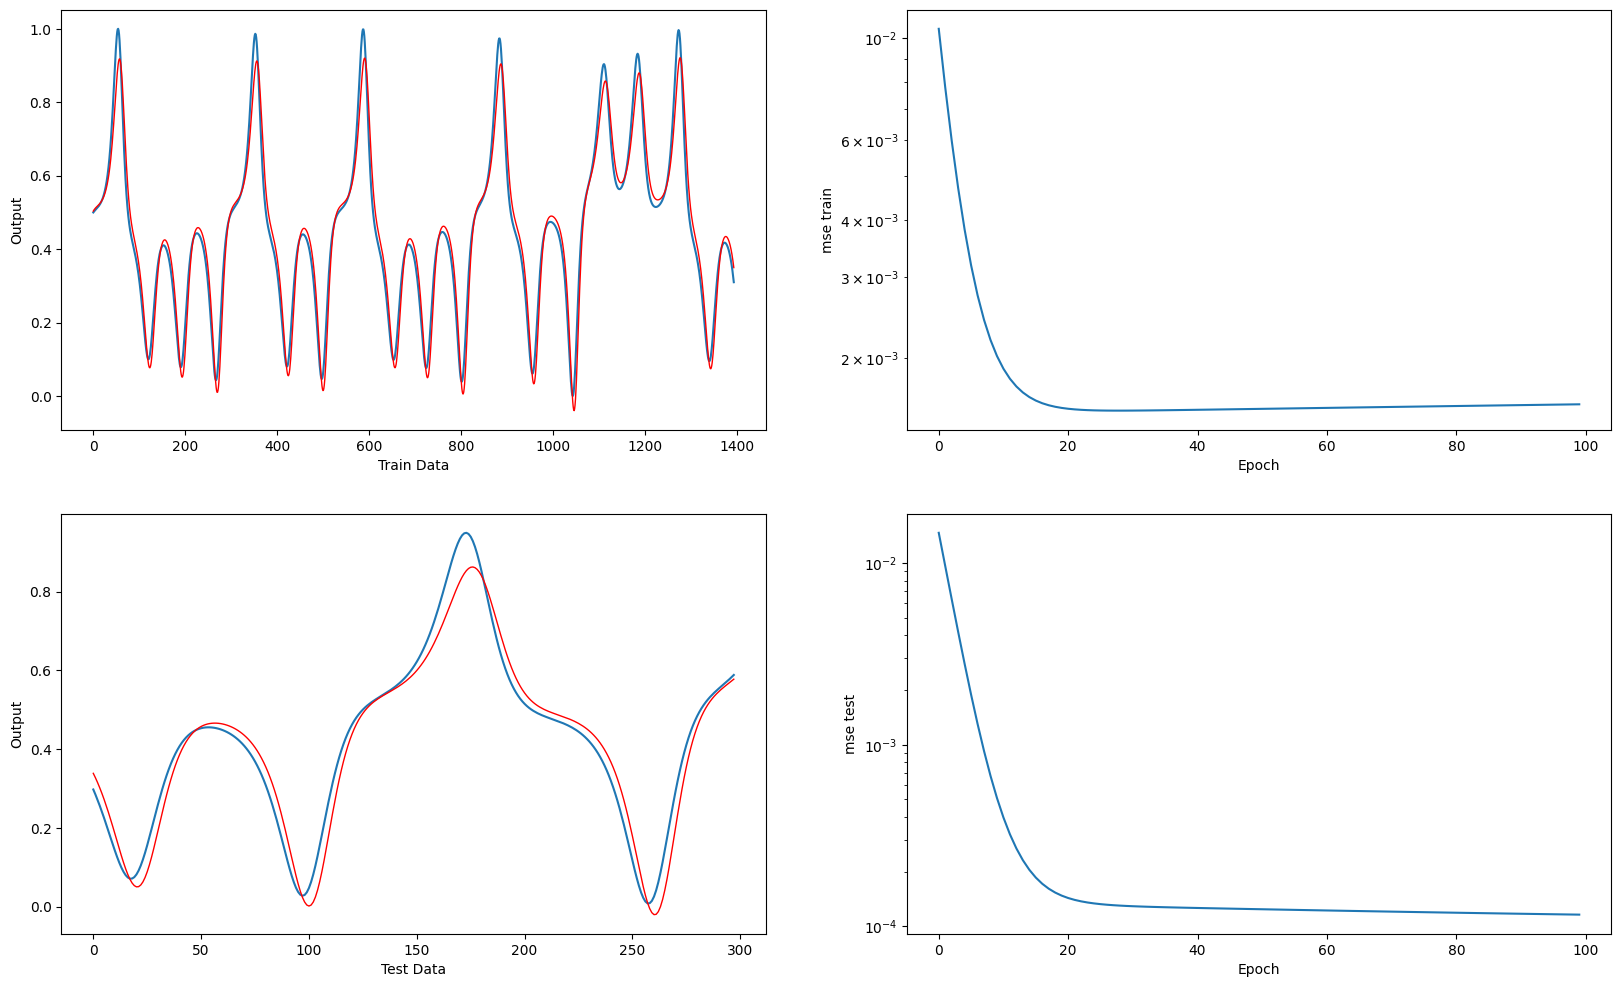

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:

# Sigmoid Activation Function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivative of Sigmoid Activation Function
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Hyperbolic Tangent (Tanh) Activation Function
def tanh(x):
    return np.tanh(x)

# Derivative of Tanh Activation Function
def tanh_derivative(x):
    return 1 - tanh(x) ** 2

# Rectified Linear Unit (ReLU) Activation Function
def relu(x):
    return np.maximum(0, x)

# Derivative of ReLU Activation Function
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Leaky ReLU Activation Function
def leaky_relu(x, alpha=0.01):
    return np.maximum(alpha * x, x)

# Derivative of Leaky ReLU Activation Function
def leaky_relu_derivative(x, alpha=0.01):
    dx = np.ones_like(x)
    dx[x < 0] = alpha
    return dx

# Define the number of input, hidden, and output neurons
n0 = X_train.shape[1]
n1 = 10
n2 = 1

alpha = 0.5
betha = 0.5
eta = 0.01
epochs = 100

# Initialize the weights with random values
np.random.seed(1)
w1 = 2 * np.random.random((n0, n1)) - 1
w2_U = 2 * np.random.random((n1, n2)) - 1
w2_L = 2 * np.random.random((n1, n2)) - 1

mse_train = []
mse_test = []

for t in range(epochs):
    output_data_train = []
    error_train = []
    #total_error = 0
    for i in range(len(X_train)):
        # Forward propagation for a single sample
        input = X_train[i:i+1]
        net1 = np.dot(input, w1)
        o1 = sigmoid(net1)
        net2_U = np.dot(o1, w2_U)
        net2_L = np.dot(o1, w2_L)
        o2_U = np.maximum(net2_L ,net2_U)
        o2_L = np.minimum(net2_L ,net2_U)
        o2 = alpha * o2_U + betha * o2_L
        target = y_train[i]
        output_data_train.append(o2[0])
        error_train = target - o2


        # Create a diagonal matrix from the 1D array
        dev_sigmoid_1 = np.array(sigmoid_derivative(o1))[0]
        f_prime_1 = np.diag(dev_sigmoid_1)

        # Update weights for a single sample
        error_train = np.array(error_train)
        # w1 = w1 + eta * error_train * input.T.dot((alpha * np.dot(((w2_U.T+w2_L.T)/2),f_prime_1)))
        w1 = w1 + eta * error_train * input.T.dot((alpha * np.dot(((alpha * w2_U.T)+(betha * w2_L.T)),f_prime_1)))
        # w2_U = w2_U + eta * 0.5 * o1.T.dot(error_train)
        # w2_L = w2_L + eta * 0.5 * o1.T.dot(error_train)
        w2_U = w2_U + eta * alpha * o1.T.dot(error_train)
        w2_L = w2_L + eta * betha * o1.T.dot(error_train)

    mse_epoch = np.mean(np.array(error_train) ** 2)
    mse_train.append(mse_epoch)

    output_data_test = []
    error_test = []
    for i in range(len(X_test)):
        # Forward propagation for a single sample
        input = X_test[i:i+1]
        net1 = np.dot(input, w1)
        o1 = sigmoid(net1)
        net2_U = np.dot(o1, w2_U)
        net2_L = np.dot(o1, w2_L)
        o2_U = np.maximum(net2_L ,net2_U)
        o2_L = np.minimum(net2_L ,net2_U)
        o2 = alpha * o2_U + betha * o2_L
        target = y_test[i]
        output_data_test.append(o2[0])
        error_test = target - o2
        error_test = np.array(error_test)
    mse_epoch = np.mean(np.array(error_test) ** 2)
    mse_test.append(mse_epoch)
    #print(mse_test)

# Plot results
plt.figure(1, figsize=(20, 12))
plt.subplot(2, 2, 1)
plt.plot(y_train)
plt.plot(output_data_train, 'r', linewidth=1)
plt.xlabel('Train Data')
plt.ylabel('Output')

plt.subplot(2, 2, 2)
plt.semilogy(mse_train)
plt.xlabel('Epoch')
plt.ylabel('mse train')

plt.subplot(2, 2, 3)
plt.plot(y_test)
plt.plot(output_data_test, 'r', linewidth=1)
plt.xlabel('Test Data')
plt.ylabel('Output')
#mse_test.reverse()
plt.subplot(2, 2, 4)
plt.semilogy(mse_test)
plt.xlabel('Epoch')
plt.ylabel('mse test')
# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()

plt.figure(2)
plt.show()

plt.figure(3)
plt.show()


mse_train_result = mse_train[-1]
mse_test_result = mse_test[-1]

# print("Final MSE for Training:", mse_train_result)
# print("Final MSE for Testing:", mse_test_result)


## Define Activation Functions

Define various activation functions and their derivatives:
- Sigmoid
- Tanh
- ReLU
- Leaky ReLU

These will be used in the rough set neural network.


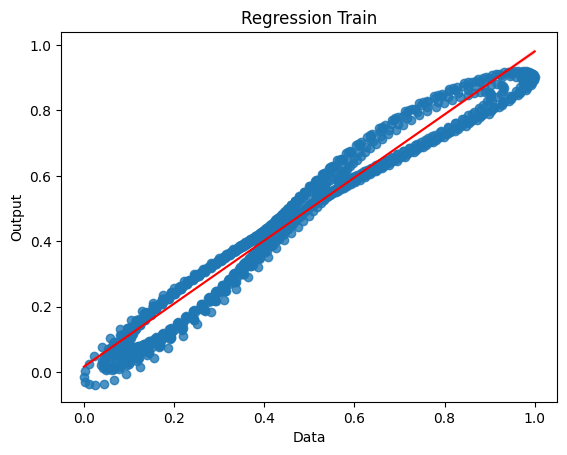

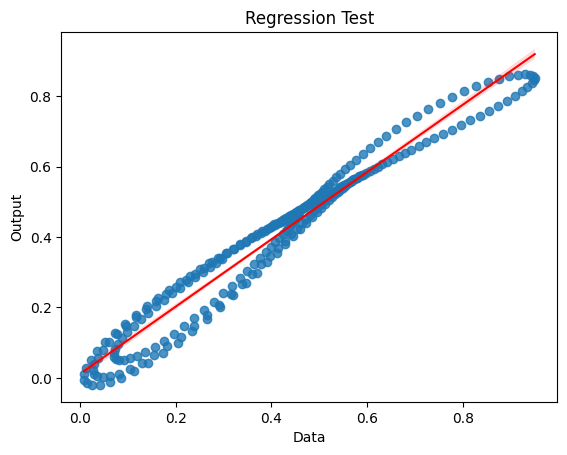

In [ ]:
import seaborn as sns
# Create a scatter plot with a regression line
plt.figure(2)
sns.regplot(x=y_train, y=output_data_train, line_kws={"linewidth": 1.5, "color": "red"})
plt.title('Regression Train')
plt.xlabel('Data')
plt.ylabel('Output')

plt.show()  # Show the plot

# Create a scatter plot with a regression line
plt.figure(3)
sns.regplot(x=y_test, y=output_data_test, line_kws={"linewidth": 1.5, "color": "red"})
plt.title('Regression Test')
plt.xlabel('Data')
plt.ylabel('Output')

plt.show()  # Show the plot

## Train Rough Set Neural Network

Train the rough set neural network:
- Uses upper and lower bound weights (w2_U and w2_L)
- Output is a combination: alpha * upper_bound + beta * lower_bound
- This creates an interval-valued prediction that handles uncertainty
- Updates weights using gradient descent with rough set theory principles


## Visualize Results

Create regression plots to visualize the relationship between actual and predicted values for both training and test sets.
